<a href="https://colab.research.google.com/github/AndyMuloki/EarlyDetectionOfAMD/blob/main/EAMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:
!mkdir ODIR-5K/Validation_Images

### Importing the necessary libraries


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [ ]:
from PIL import Image
import glob
import random

In [ ]:
import matplotlib.pyplot as plt
import IPython.display as display

### Defining the Batch Size and the Class Names

In [ ]:
BATCH_SIZE = 32
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

training_images_file = 'ODIR-5K/Training Images'
testing_images_file = 'ODIR-5K/Testing Images'
labels_file = 'ODIR-5K/data.xlsx'

# Dictionary mapping of specific diagnostic keywords with disease label

# Labels that are not needed are deleted
diseases = {'abnormal pigment ': 'O', 'age-related macular degeneration': 'A', 'anterior segment image': 'DELETE', 'arteriosclerosis': 'O', 'asteroid hyalosis': 'O', 'atrophic change': 'O', 'atrophy': 'O', 'branch retinal artery occlusion': 'O', 'branch retinal vein occlusion': 'O', 'cataract': 'C', 'central serous chorioretinopathy': 'O', 'chorioretinal atrophy': 'O', 'choroidal nevus': 'NaN', 'depigmentation of the retinal pigment epithelium': 'O', 'diabetic retinopathy': 'D', 'drusen': 'O', 'dry age-related macular degeneration': 'A', 'epiretinal membrane': 'O', 'epiretinal membrane over the macula': 'O', 'fundus laser photocoagulation spots': 'O', 'glaucoma': 'G', 'glial remnants anterior to the optic disc': 'O', 'hypertensive retinopathy': 'H', 'hypertensive retinopathy,diabetic retinopathy': 'D', 'idiopathic choroidal neovascularization': 'O', 'image offset': 'DELETE', 'laser spot': 'O', 'lens dust': 'DELETE', 'low image quality': 'DELETE', 'low image quality,maculopathy': 'DELETE', 'macular coloboma': 'O', 'macular pigmentation disorder': 'NaN', 'maculopathy': 'O', 'mild nonproliferative retinopathy': 'D', 'moderate non proliferative retinopathy': 'D', 'morning glory syndrome': 'O', 'myelinated nerve fibers': 'O', 'myopia retinopathy': 'M', 'myopic maculopathy': 'M', 'myopic retinopathy': 'M', 'no fundus image': 'DELETE', 'normal fundus': 'N', 'old branch retinal vein occlusion': 'O', 'optic disk photographically invisible': 'DELETE', 'optic nerve atrophy': 'O', 'oval yellow-white atrophy': 'O', 'pathological myopia': 'M', 'peripapillary atrophy': 'O', 'pigment epithelium proliferation': 'O', 'pigmentation disorder': 'O', 'post laser photocoagulation': 'O', 'post retinal laser surgery': 'O', 'proliferative diabetic retinopathy': 'D', 'punctate inner choroidopathy': 'O', 'refractive media opacity': 'O', 'retina fold': 'O', 'retinal artery macroaneurysm': 'O', 'retinal detachment': 'O', 'retinal pigment epithelial hypertrophy': 'O', 'retinal pigment epithelium atrophy': 'O', 'retinal pigmentation': 'O', 'retinal vascular sheathing': 'O', 'retinitis pigmentosa': 'O', 'retinochoroidal coloboma': 'O', 'rhegmatogenous retinal detachment': 'O', 'severe nonproliferative retinopathy': 'D', 'severe proliferative diabetic retinopathy': 'D', 'silicone oil eye': 'O', 'spotted membranous change': 'O', 'suspected abnormal color of  optic disc': 'O', 'suspected cataract': 'C', 'suspected diabetic retinopathy': 'D', 'suspected glaucoma': 'G', 'suspected macular epimacular membrane': 'O', 'suspected microvascular anomalies': 'O', 'suspected moderate non proliferative retinopathy': 'D', 'suspected retinal vascular sheathing': 'O', 'suspected retinitis pigmentosa': 'O', 'suspicious diabetic retinopathy': 'D', 'tessellated fundus': 'O', 'vascular loops': 'O', 'vessel tortuosity': 'O', 'wet age-related macular degeneration': 'A'}

# print(diseases)

{'abnormal pigment ': 'O', 'age-related macular degeneration': 'A', 'anterior segment image': 'DELETE', 'arteriosclerosis': 'O', 'asteroid hyalosis': 'O', 'atrophic change': 'O', 'atrophy': 'O', 'branch retinal artery occlusion': 'O', 'branch retinal vein occlusion': 'O', 'cataract': 'C', 'central serous chorioretinopathy': 'O', 'chorioretinal atrophy': 'O', 'choroidal nevus': 'NaN', 'depigmentation of the retinal pigment epithelium': 'O', 'diabetic retinopathy': 'D', 'drusen': 'O', 'dry age-related macular degeneration': 'A', 'epiretinal membrane': 'O', 'epiretinal membrane over the macula': 'O', 'fundus laser photocoagulation spots': 'O', 'glaucoma': 'G', 'glial remnants anterior to the optic disc': 'O', 'hypertensive retinopathy': 'H', 'hypertensive retinopathy,diabetic retinopathy': 'D', 'idiopathic choroidal neovascularization': 'O', 'image offset': 'DELETE', 'laser spot': 'O', 'lens dust': 'DELETE', 'low image quality': 'DELETE', 'low image quality,maculopathy': 'DELETE', 'macula

In [ ]:
#loading labels to pandas
labels = pd.read_excel(labels_file, index_col=0)

In [ ]:
print(labels['Right-Diagnostic Keywords'][0])

normal fundus


### Labelling images and renaming them. Filtering out low quality fundus images

In [ ]:
file_path = 'ODIR-5K/Training Images'
all_paths = []
for element in glob.glob(file_path+"/*.jpg"):
  all_paths.append(element)
paths = []

#adding label information to image names
for u_id in labels.index:
  labelL = ""
  labelR = ""
  leftDiagnosis = labels['Left-Diagnostic Keywords'][u_id]
  rightDiagnosis = labels['Right-Diagnostic Keywords'][u_id]
  leftDiagnosis = leftDiagnosis.split(", ")
  rightDiagnosis = rightDiagnosis.split(", ")

  for d in leftDiagnosis:
    if d in diseases:
        if labelL != "":
          labelL+="&"+diseases[d]
        else:
          labelL+=diseases[d]
    else:
        labelL+="DELETE"
  for d in rightDiagnosis:
    if d in diseases:
      if labelR != "":
        labelR+="&"+diseases[d]
      else:
        labelR+=diseases[d]
    else:
      labelR+="DELETE"

  if file_path+"/"+str(labels['Left-Fundus'][u_id]) in all_paths:
    filename = str(labels['Left-Fundus'][u_id]).split(".")
    os.rename(file_path+"/"+str(labels['Left-Fundus'][u_id]), file_path+"/"+filename[0]+"-"+labelL+".jpg")
    paths.append(file_path+"/"+str(labels['Left-Fundus'][u_id])+"/"+labelL)

  if file_path+"/"+str(labels['Right-Fundus'][u_id]) in all_paths:
    filename = str(labels['Right-Fundus'][u_id]).split(".")
    os.rename(file_path+"/"+str(labels['Right-Fundus'][u_id]), file_path+"/"+filename[0]+"-"+labelR+".jpg")
    paths.append(file_path+"/"+str(labels['Right-Fundus'][u_id])+"/"+labelR)


**was successful**

**Deleting low quality Images**

In [ ]:
#deleting low quality images    
items_to_remove = []
add_mix_info = []

for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
    img_name = element.split("/")[-1]
    img_label = img_name.split("-")
    if "DELETE" in img_label[-1]:
      items_to_remove.append(element)
    elif "&" in img_label[-1]:
      add_mix_info.append(element)

for e in items_to_remove:
  os.remove(e)

for e in add_mix_info:
  pom = e.split(".")
  os.rename(e, pom[0]+"&X"+".jpg")      

**was successful**

**Enhancing Images and resizing. Creating validation set**

In [ ]:
import cv2 as cv

def loadAndCropCenterResizeCV2(img, newSize):
    #img = cv.imread(imgPath)
    width, height, ______ = img.shape
    if width == height:
        return cv.resize(img, newSize)
    length = min(width, height)
    left = (width - length) // 2
    top = (height - length) // 2
    right = (width + length) // 2
    bottom = (height + length) // 2
    return cv.resize(img[left:right, top:bottom, :], newSize)

def clahe_resize(impath):
  img = cv.imread(impath)
  # resizing image to size; 250 by 250 pixels
  eq_image = loadAndCropCenterResizeCV2(img, (250, 250))
  
  cv.imwrite(impath,eq_image)

In [ ]:
# enhancing and resizing images
all_paths = []
for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
  all_paths.append(element)
  clahe_resize(element)

#creating validation set
num_to_select = 1450                        
list_of_random_items = random.sample(all_paths, num_to_select)
for element in list_of_random_items:
  p = element.split("/")
  os.replace(element, "ODIR-5K/Validation_Images/"+p[-1])

**was successful: took 7m 30s on GPU**

**successful: completed in 3m 6s**

In [ ]:
def show_class_distribution():
  N = 0
  A = 0 
  for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
    img_name = element.split("/")[-1]
    img_label = img_name.split("-")
    if img_label[-1] == "N.jpg":
      N += 1
    elif img_label[-1] == "A.jpg":
      A +=1
    elif "&" in img_label[-1]:
      X +=1  
  print(N, A)

In [ ]:
show_class_distribution()

2103 174


### Selecting images for training from the 'Training Images' folder.

In [ ]:
import os
import glob

items_to_remove = []
all_elements_train = 0
all_elements_val = 0
for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[-1] != "N.jpg" and img_label[-1] != "A.jpg":
    items_to_remove.append(element)
  else:
    all_elements_train+=1
  
for element in glob.glob("ODIR-5K/Validation_Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[-1] != "N.jpg" and img_label[-1] != "A.jpg":
    items_to_remove.append(element)
  else: 
    all_elements_val+=1
  
for e in items_to_remove:
  os.remove(e)


In [ ]:
print(all_elements_train, all_elements_val)

2277 776


In [ ]:
import tensorflow as tf
import pandas as pd
import os

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display

In [ ]:
import numpy as np
import glob
import random

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 250
IMG_WIDTH = 250
CLASS_NAMES = ['N', 'A']

In [ ]:
resampled1_ds =  tf.data.Dataset.list_files("ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

In [ ]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  label = tf.strings.bytes_split(label[0])
  l = [0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'A':
        l[1] = 1
  return l

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

label:  N [1 0]
label:  N [1 0]
label:  N [1 0]
label:  N [1 0]
label:  N [1 0]
label:  A [0 1]


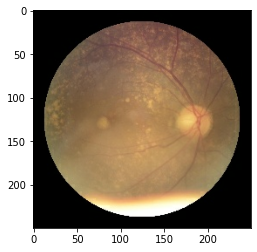

In [ ]:
for image, label in resampled_named_ds.take(6):
  plt.imshow(image.numpy())
  print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [ ]:
def randomly_augment(image,label):
  image = tf.image.random_flip_left_right(image)
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  ds = ds.cache()
  ds = ds.batch(32, drop_remainder=True)
  ds = ds.repeat()

  return ds

In [ ]:
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=3000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)

[1 0]


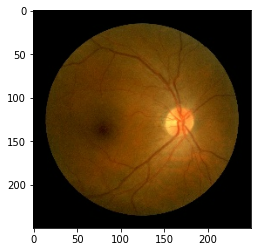

In [ ]:
for example in final_train_ds.take(1):
  image, label = example
  break

im, lab = image[17], label[17]
plt.imshow(im.numpy())
print(lab.numpy())

### Training begins...

In [ ]:
model_cnn = tf.keras.Sequential([
    
    # 1st VGG block
    tf.keras.layers.Conv2D(32, (5, 5), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(32, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    #2nd VGG block
    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(2, activation = 'softmax')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 250, 250, 32)      2432      
                                                                 
 batch_normalization_4 (Batc  (None, 250, 250, 32)     96        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 250, 250, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 250, 250, 32)      25632     
                                                                 
 batch_normalization_5 (Batc  (None, 250, 250, 32)     96        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 250, 250, 32)     

**Epochs are defined here...**

In [ ]:
history_cnn = model_cnn.fit(final_train_ds,
                    #batch_size=32,
                    epochs=12,
                    steps_per_epoch = 100, #train_elements/batch_size
                    validation_data=final_test_ds,
                    validation_steps = 33,
                    use_multiprocessing=True,                    
                    )

Epoch 1/12
100/100 [==============================] - 30s 227ms/step - loss: 0.3004 - accuracy: 0.9144 - precision_1: 0.9144 - recall_1: 0.9144 - val_loss: 0.3810 - val_accuracy: 0.9149 - val_precision_1: 0.9149 - val_recall_1: 0.9149
Epoch 2/12
100/100 [==============================] - 23s 225ms/step - loss: 0.3188 - accuracy: 0.9109 - precision_1: 0.9109 - recall_1: 0.9109 - val_loss: 0.3779 - val_accuracy: 0.9192 - val_precision_1: 0.9192 - val_recall_1: 0.9192
Epoch 3/12
100/100 [==============================] - 22s 224ms/step - loss: 0.2837 - accuracy: 0.9116 - precision_1: 0.9116 - recall_1: 0.9116 - val_loss: 0.4056 - val_accuracy: 0.9170 - val_precision_1: 0.9170 - val_recall_1: 0.9170
Epoch 4/12
100/100 [==============================] - 22s 225ms/step - loss: 0.2792 - accuracy: 0.9187 - precision_1: 0.9187 - recall_1: 0.9187 - val_loss: 0.3768 - val_accuracy: 0.9159 - val_precision_1: 0.9159 - val_recall_1: 0.9159
Epoch 5/12
100/100 [==============================] - 22s 22

In [ ]:
model_cnn.evaluate(final_test_ds, steps=100)